In [3]:
import os
%pwd
os.chdir("../")
%pwd

'd:\\ML_Projects'

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
import seaborn as sns
import torchaudio
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score

transform and load data

In [2]:
transform = transforms.Compose(
    [transforms.Resize((100,100)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))])

In [4]:
batch_size = 4
trainset = torchvision.datasets.ImageFolder(root='dataset/audio_classification/spectrom/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.ImageFolder(root='dataset/audio_classification/spectrom/test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [5]:
CLASSES = ['artifact', 'extrahls', 'murmur', 'normal']
NUM_CLASSES = len(CLASSES)

In [7]:
class spectrogramClassificationNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size= 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels= 16, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16*25*25, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, NUM_CLASSES)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

In [8]:
# input = torch.rand(1, 1, 100, 100) # BS, C, H, W
model = spectrogramClassificationNet()      
# model(input).shape

In [9]:
loss_fn=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


TRAINING

In [10]:
losses_epoch_mean = []
NUM_EPOCHS = 100

for epoch in range(NUM_EPOCHS):
    losses_epoch = []
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        losses_epoch.append(loss.item())
    losses_epoch_mean.append(np.mean(losses_epoch))
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, loss: {np.mean(losses_epoch)}')

c:\Users\prane\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1/100, loss: 1.3812881478896508
Epoch 2/100, loss: 1.211012588097499
Epoch 3/100, loss: 0.9718345632919898
Epoch 4/100, loss: 0.8166939788139783
Epoch 5/100, loss: 0.7505229539596118
Epoch 6/100, loss: 0.693524416249532
Epoch 7/100, loss: 0.6505554737523198
Epoch 8/100, loss: 0.6557525070384145
Epoch 9/100, loss: 0.6266595056379349
Epoch 10/100, loss: 0.5739955548197031
Epoch 11/100, loss: 0.5361750454355317
Epoch 12/100, loss: 0.6091134075361949
Epoch 13/100, loss: 0.6019886703445361
Epoch 14/100, loss: 0.5489187652531725
Epoch 15/100, loss: 0.5040504250388879
Epoch 16/100, loss: 0.4692905844332507
Epoch 17/100, loss: 0.4676717952466928
Epoch 18/100, loss: 0.530535911818823
Epoch 19/100, loss: 0.5109866863618103
Epoch 20/100, loss: 0.45429891204604733
Epoch 21/100, loss: 0.3932109356213073
Epoch 22/100, loss: 0.40545302618724793
Epoch 23/100, loss: 0.5379122363833281
Epoch 24/100, loss: 0.4320020977980815
Epoch 25/100, loss: 0.386021849556038
Epoch 26/100, loss: 0.37068087065451

LOSSES

<Axes: >

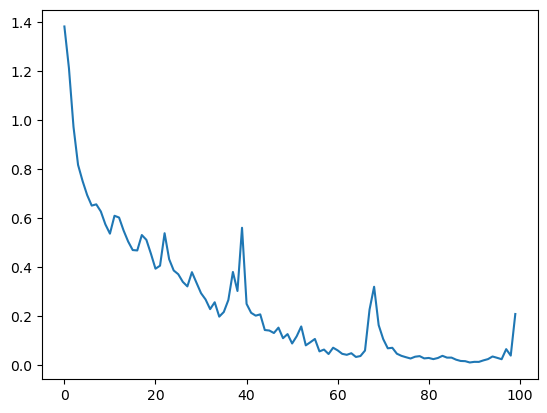

In [11]:
sns.lineplot(x=list(range(len(losses_epoch_mean))), y=losses_epoch_mean)

TESTING

In [12]:
y_test = []
y_test_hat = []
for i, data in enumerate(testloader, 0):
    inputs, y_test_temp = data
    with torch.no_grad():
        y_test_hat_temp = model(inputs).round()
    
    y_test.extend(y_test_temp.numpy())
    y_test_hat.extend(y_test_hat_temp.numpy())

c:\Users\prane\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [13]:
acc = accuracy_score(y_test, np.argmax(y_test_hat, axis=1))
print(f'Accuracy: {acc*100:.2f} %')

Accuracy: 56.00 %


In [14]:
# Convert probabilities to predicted labels for multi-class classification
y_pred = np.argmax(y_test_hat, axis=1)

# Precision, Recall, and F1-score for multi-class classification
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

Precision: 51.99%
Recall: 50.15%
F1-Score: 49.10%


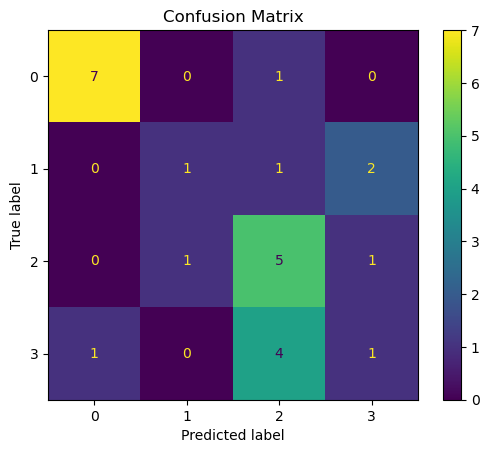

In [15]:
# y_test_hat_list=[y_hat.item() for i,y_hat in enumerate(y_test_hat)]
# Plot confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title('Confusion Matrix')
plt.show()

In [16]:
torch.save(model.state_dict(), 'artifacts/cnn_audio_classification.pth')

Inference

In [18]:
model_loaded = spectrogramClassificationNet()
model_loaded.load_state_dict(torch.load('artifacts/cnn_audio_classification.pth'))
model_loaded.eval()

spectrogramClassificationNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=10000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
  (relu): ReLU()
  (softmax): LogSoftmax(dim=None)
)

In [20]:
def plot_specgram(waveform, sample_rate, file_path = 'test2.png'):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    
    fig, axes = plt.subplots( num_channels, 1)
    fig.set_size_inches(10, 10)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    plt.gca().set_axis_off()
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    # plt.show(block=False)
    plt.savefig(file_path, bbox_inches='tight', pad_inches = 0)

In [26]:
def sepctro_img(audio_path,sepcto_path="dataset/audio_classification/raw_data/test.png"):
    data_waveform, sr = torchaudio.load(audio_path)
    plot_specgram(waveform=data_waveform, sample_rate=sr, file_path=sepcto_path)
    return sepcto_path


In [25]:
audio_path="dataset/audio_classification/raw_data/set_a/artifact__201012172012.wav"
sepcto_path="dataset/audio_classification/raw_data/test.png"

c:\Users\prane\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Predicted class: artifact


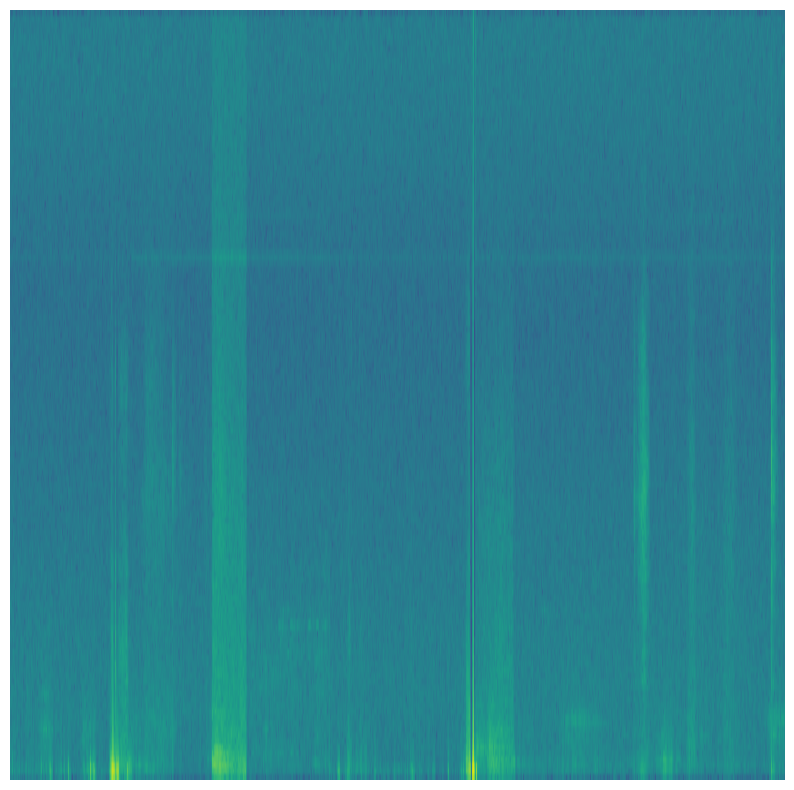

In [30]:
spectro_img_path=sepctro_img(audio_path=audio_path) 
img = Image.open(spectro_img_path)
img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0)
with torch.no_grad():
    result = model_loaded(img_tensor).round()
    pred=torch.argmax(result).item()

    # Print the predicted class
    print(f"Predicted class: {CLASSES[pred]}")